In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 忽略警告
import warnings
warnings.filterwarnings('ignore')
# 读取训练集和测试集
train = pd.read_csv('train.csv')
train_len = len(train)
test = pd.read_csv('test.csv')

In [2]:
# 查看训练集
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# 查看测试集, 缺少最后一列SalePrice
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# 合并训练集和测试集,去掉房价一列
all_data = pd.concat([train, test], axis = 0, ignore_index= True)
all_data.drop(labels = ["SalePrice"],axis = 1, inplace = True)

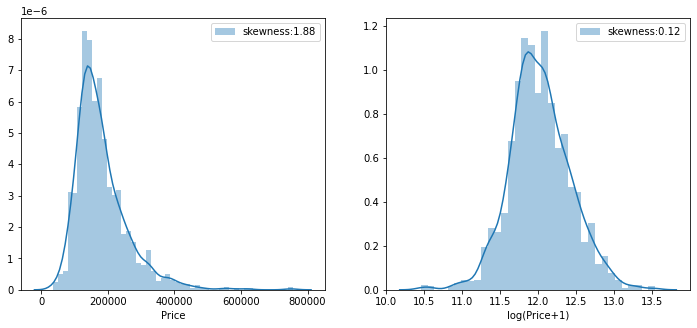

In [5]:
# 查看训练集的房价分布，左图是原始房价分布，右图是将房价对数化之后的分布
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['SalePrice'],hist = True,label='skewness:{:.2f}'.format(train['SalePrice'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Price')
g2 = sns.distplot(np.log1p(train['SalePrice']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['SalePrice']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Price+1)')
plt.show()

In [6]:
# 由于房价是有偏度的,将房价对数化
train['SalePrice'] = np.log1p(train['SalePrice'])  

In [7]:
# 将有偏的数值特征对数化
num_features_list = list(all_data.dtypes[all_data.dtypes != "object"].index)

for i in num_features_list:
    if all_data[i].dropna().skew() > 0.75:
        all_data[i] = np.log1p(all_data[i])

# 将类别数值转化为虚拟变量
all_data = pd.get_dummies(all_data)   

In [8]:
# 查看缺失值
all_data.isnull().sum()

Id                         0
MSSubClass                 0
LotFrontage              486
LotArea                    0
OverallQual                0
                        ... 
SaleCondition_AdjLand      0
SaleCondition_Alloca       0
SaleCondition_Family       0
SaleCondition_Normal       0
SaleCondition_Partial      0
Length: 289, dtype: int64

In [9]:
# 将缺失值用该列的均值填充
all_data = all_data.fillna(all_data.mean())

In [10]:
# 将测试集和训练集分开
X_train = all_data[:train_len]
X_test = all_data[train_len:]
Y_train = train['SalePrice']

In [11]:
from sklearn.linear_model import Ridge, LassoCV
from sklearn.model_selection import cross_val_score

# 定义交叉验证,用均方根误差来评价模型的拟合程度
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, Y_train, scoring = 'neg_mean_squared_error', cv=5))
    return rmse

In [13]:
# Ridge模型
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = a)).mean() for a in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge

0.05     0.138886
0.10     0.137706
0.30     0.134898
1.00     0.131176
3.00     0.128393
5.00     0.127533
10.00    0.126995
15.00    0.127153
30.00    0.128569
50.00    0.130716
75.00    0.133112
dtype: float64

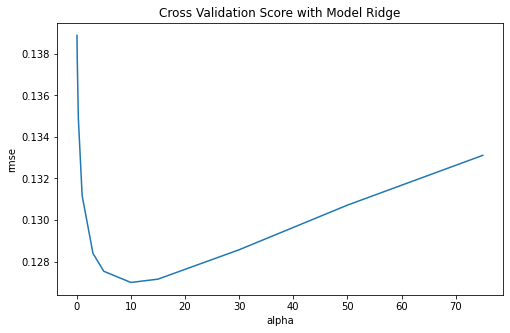

In [15]:
# 交叉验证可视化
fig = plt.figure(figsize=(8,5))
cv_ridge.plot(title = 'Cross Validation Score with Model Ridge')
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [16]:
# 当alpha为10时,均方根误差最小
cv_ridge.min()

0.12699476769354776

In [17]:
# lasso模型,均方根误差的均值更小,因此最终选择lasso模型
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, Y_train)
rmse_cv(model_lasso).mean()

0.12265837643695984

In [18]:
# 查看模型系数, lasso模型能选择特征,将不重要的特征系数设置为0
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked {} variables and eliminated the other {} variables".format(sum(coef != 0), sum(coef==0)))

Lasso picked 110 variables and eliminated the other 179 variables


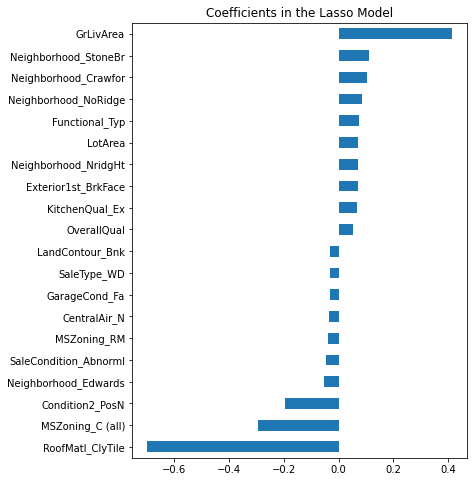

In [19]:
# 查看重要的特征, GrLivArea地上面积是最重要的正相关特征
imp_coef = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
fig = plt.figure(figsize=(6,8))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

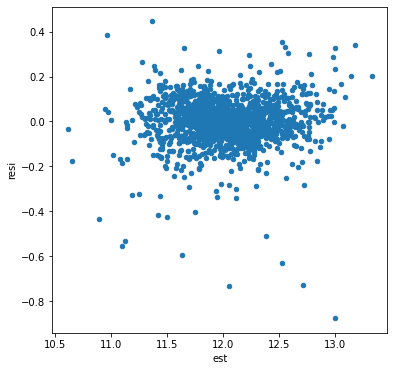

In [20]:
# 查看残差
est = pd.DataFrame({"est":model_lasso.predict(X_train), "true":Y_train})
plt.rcParams["figure.figsize"] = [6,6]
est["resi"] = est["true"] - est["est"]
est.plot(x = "est", y = "resi",kind = "scatter")
plt.show()

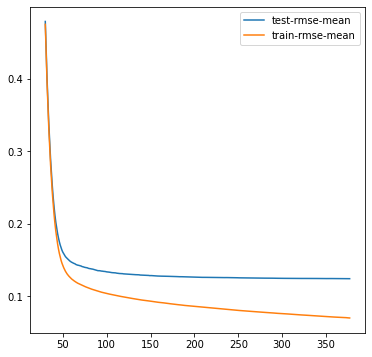

In [21]:
# xgboost模型
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = Y_train)
dtest = xgb.DMatrix(X_test)
# 交叉验证
params = {"max_depth":2, "eta":0.1}
cv_xgb = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
cv_xgb.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

In [22]:
# 训练模型
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) 
model_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

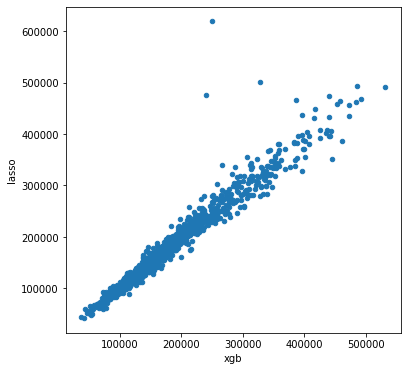

In [23]:
# 查看两种模型的预测结果, 将结果指数化
lasso_preds = np.expm1(model_lasso.predict(X_test))
xgb_preds = np.expm1(model_xgb.predict(X_test))
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
plt.show()

In [24]:
# 最终结果采用两种模型预测的加权平均值,提交结果
preds = 0.7*lasso_preds + 0.3*xgb_preds
result = pd.DataFrame({"id":test.Id, "SalePrice":preds})
result.head()

,id,SalePrice
0,1461,119615.323834
1,1462,152121.159158
2,1463,181875.581525
3,1464,195300.422552
4,1465,197045.716540


In [25]:
result.to_csv('result.csv', index = False)